In [87]:
import os
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import kagglehub
import math

In [88]:
#1 dataset z kaggle
path = kagglehub.dataset_download("msambare/fer2013")
print("dataset path:", path)

dataset path: C:\Users\matiu\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [89]:
#2 wczytanie do numpy
emotions = ['angry','disgust','fear','happy','neutral','sad','surprise']

def load_fer2013_dataset(path, emotions_list):
    X_train_list = []
    y_train_list = []
    X_test_list  = []
    y_test_list  = []

    for idx, emo in enumerate(emotions_list):
        train_files = os.path.join(path, 'train', emo, '*.jpg')
        for file_path in glob.glob(train_files):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            X_train_list.append(img)
            y_train_list.append(idx)

        test_files = os.path.join(path, 'test', emo, '*.jpg')
        for file_path in glob.glob(test_files):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            X_test_list.append(img)
            y_test_list.append(idx)

    X_train = np.array(X_train_list, dtype='float32')
    y_train = np.array(y_train_list, dtype='int64')
    X_test  = np.array(X_test_list,  dtype='float32')
    y_test  = np.array(y_test_list,  dtype='int64')
    return X_train, y_train, X_test, y_test

X_train_np, y_train_np, X_test_np, y_test_np = load_fer2013_dataset(path, emotions)

print("rozmiar X_train:", X_train_np.shape, "y_train:", y_train_np.shape)
print("rozmiar X_test: ", X_test_np.shape,  "y_test: ", y_test_np.shape)

rozmiar X_train: (28709, 48, 48) y_train: (28709,)
rozmiar X_test:  (7178, 48, 48) y_test:  (7178,)


x_train po reshape: (28709, 1, 48, 48)


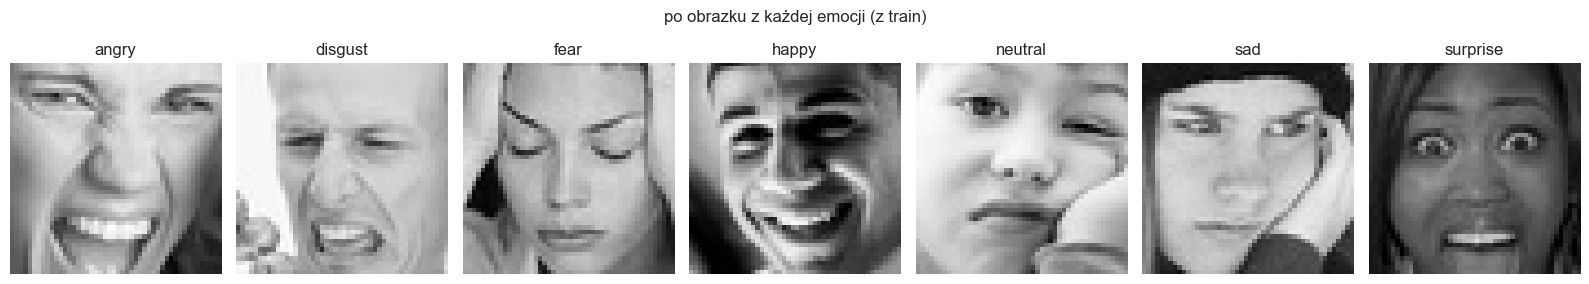

In [90]:
#3 normalizacja reshape i podgląd emocji
X_train_np /= 255.0
X_test_np  /= 255.0

#reshape do [N, 1, 48, 48]
X_train_np = np.expand_dims(X_train_np, axis=1)
X_test_np  = np.expand_dims(X_test_np,  axis=1)
print("x_train po reshape:", X_train_np.shape)

#po obrazku z każdej z 7 emocji
fig, axes = plt.subplots(1, 7, figsize=(16,3))
for i, emo_name in enumerate(emotions):
    idxs = np.where(y_train_np == i)[0]
    chosen = random.choice(idxs)
    img_2d = X_train_np[chosen][0]  #shape (48,48)
    axes[i].imshow(img_2d, cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(emo_name)
    axes[i].axis('off')
plt.suptitle("po obrazku z każdej emocji (z train)")
plt.tight_layout()
plt.show()

In [91]:
#4 datasety i loadery
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("urządzenie:", device)

X_train_t = torch.from_numpy(X_train_np)  #shape (N,1,48,48)
y_train_t = torch.from_numpy(y_train_np)
X_test_t  = torch.from_numpy(X_test_np)
y_test_t  = torch.from_numpy(y_test_np)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

urządzenie: cuda


In [92]:
#5 model CNN z dwiema warstwami dense (fc1, fc2)
class MyCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.fc1   = nn.Linear(64*12*12, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyCNN(num_classes=len(emotions)).to(device)
print(model)

MyCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


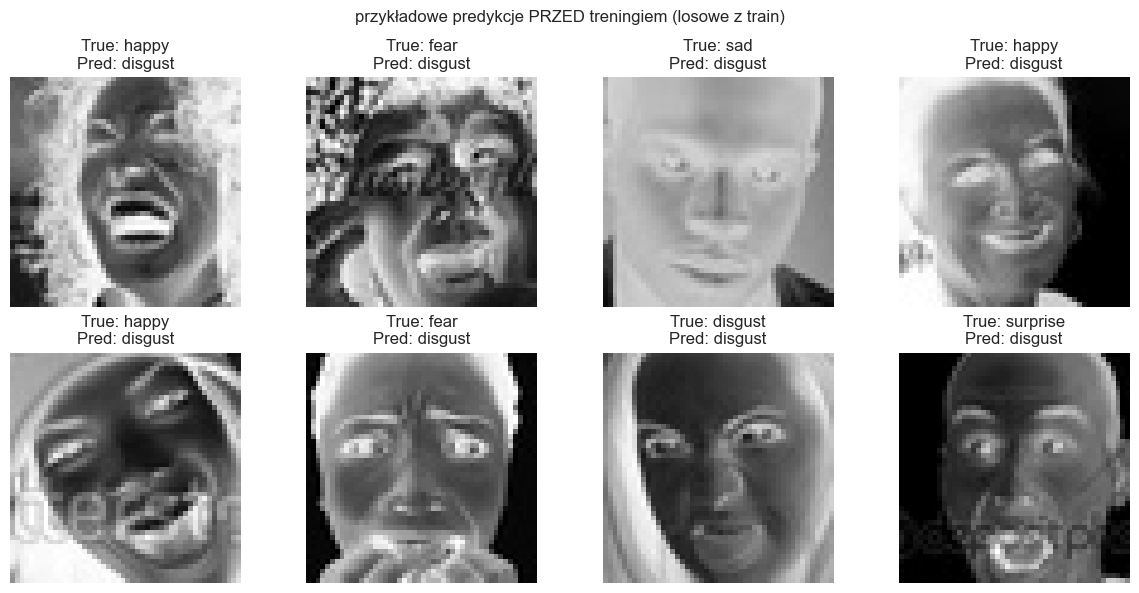

In [93]:
#6 predykcje PRZED treningiem (model nieztrenowany)
fig, axes = plt.subplots(2, 4, figsize=(12,6))
axes = axes.flatten()
model.eval()

with torch.no_grad():
    for i in range(8):
        idx = random.randint(0, len(X_train_np)-1)
        img_2d = X_train_np[idx][0]   # (48,48)
        true_label = y_train_np[idx]

        #batch dimension (1,1,48,48)
        img_tensor = torch.from_numpy(X_train_np[idx]).unsqueeze(0).to(device)
        out = model(img_tensor)
        _, pred_label = torch.max(out,1)
        pred_label = pred_label.item()

        axes[i].imshow(img_2d, cmap='gray_r', vmin=0, vmax=1)
        axes[i].set_title(f"True: {emotions[true_label]}\nPred: {emotions[pred_label]}")
        axes[i].axis('off')

plt.suptitle("przykładowe predykcje PRZED treningiem (losowe z train)")
plt.tight_layout()
plt.show()


In [94]:
#7 ustawienia optymalizatora, scheduler, mse i funkcje epok
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def compute_mse(outputs, labels, num_c=7):
    p = F.softmax(outputs, dim=1).detach().cpu().numpy()
    lab = labels.detach().cpu().numpy()
    oh  = np.eye(num_c)[lab]
    return np.mean((p - oh)**2)

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_mse, correct = 0.0, 0.0, 0
    samples = 0

    for (inputs, labels) in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(inputs)
        loss = F.cross_entropy(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        m = compute_mse(out, labels)
        total_mse += m * inputs.size(0)
        _, pred = torch.max(out, 1)
        correct += (pred == labels).sum().item()
        samples += labels.size(0)

    return total_loss/samples, total_mse/samples, correct/samples

def eval_one_epoch(model, loader):
    model.eval()
    total_loss, total_mse, correct = 0.0, 0.0, 0
    samples = 0

    with torch.no_grad():
        for (inputs, labels) in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            out = model(inputs)
            l   = F.cross_entropy(out, labels)

            total_loss += l.item() * inputs.size(0)
            m = compute_mse(out, labels)
            total_mse += m * inputs.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == labels).sum().item()
            samples += labels.size(0)

    return total_loss/samples, total_mse/samples, correct/samples

In [95]:
#8 pętla treningowa i early stopping

num_epochs = 30 #liczab epok

#parametry early stopping można zmienić
early_stopping_threshold = 0.0001  
max_patience = 18            
best_val_mse = float('inf')
patience_counter = 0

train_losses, train_mses, train_accs = [], [], []
val_losses, val_mses, val_accs = [], [], []

for epoch in range(num_epochs):
    tr_loss, tr_mse, tr_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_mse, val_acc = eval_one_epoch(model, test_loader)
    scheduler.step()

    train_losses.append(tr_loss)
    train_mses.append(tr_mse)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_mses.append(val_mse)
    val_accs.append(val_acc)

    print(f"epoch {epoch+1}/{num_epochs} | "
          f"train loss={tr_loss:.4f}, MSE={tr_mse:.4f}, Acc={tr_acc:.4f} | "
          f"val loss={val_loss:.4f}, MSE={val_mse:.4f}, Acc={val_acc:.4f}")

    #1 warunek MSE < threshold
    if val_mse < early_stopping_threshold:
        print(f"early stop - val_mse {val_mse:.4f} < {early_stopping_threshold}")
        break

    #2 patience (brak poprawy MSE)
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("early stop - brak poprawy MSE przez >= max_patience epok")
            break

epoch 1/30 | train loss=1.7627, MSE=0.1156, Acc=0.2815 | val loss=1.6898, MSE=0.1110, Acc=0.3385
epoch 2/30 | train loss=1.6257, MSE=0.1076, Acc=0.3664 | val loss=1.5554, MSE=0.1033, Acc=0.3998
epoch 3/30 | train loss=1.5195, MSE=0.1013, Acc=0.4161 | val loss=1.4618, MSE=0.0979, Acc=0.4379
epoch 4/30 | train loss=1.4167, MSE=0.0953, Acc=0.4571 | val loss=1.3961, MSE=0.0945, Acc=0.4653
epoch 5/30 | train loss=1.3312, MSE=0.0904, Acc=0.4910 | val loss=1.3304, MSE=0.0905, Acc=0.4861
epoch 6/30 | train loss=1.2592, MSE=0.0860, Acc=0.5200 | val loss=1.3200, MSE=0.0901, Acc=0.4850
epoch 7/30 | train loss=1.1861, MSE=0.0817, Acc=0.5522 | val loss=1.3429, MSE=0.0910, Acc=0.4873
epoch 8/30 | train loss=1.1035, MSE=0.0766, Acc=0.5864 | val loss=1.2734, MSE=0.0869, Acc=0.5169
epoch 9/30 | train loss=1.0209, MSE=0.0712, Acc=0.6230 | val loss=1.2868, MSE=0.0872, Acc=0.5157
epoch 10/30 | train loss=0.9304, MSE=0.0657, Acc=0.6562 | val loss=1.2933, MSE=0.0866, Acc=0.5295
epoch 11/30 | train loss=0.72

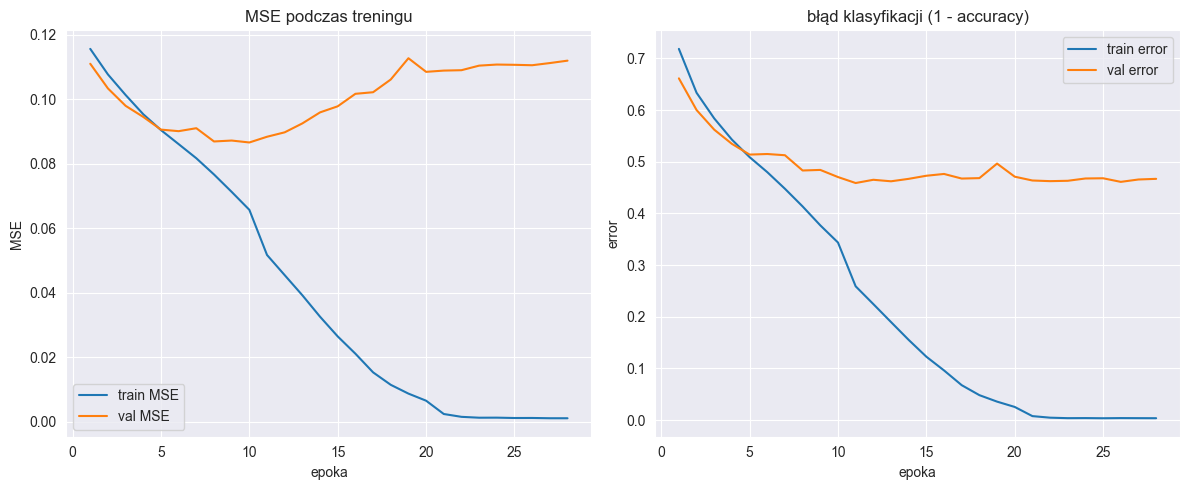

In [96]:
#9 wykresy mse i błędyu klasyfikacji

#po pętli (koniec treningu):
epochs_run = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))
#wykres MSE
plt.subplot(1,2,1)
plt.plot(epochs_run, train_mses, label='train MSE')
plt.plot(epochs_run, val_mses,   label='val MSE')
plt.title('MSE podczas treningu')
plt.xlabel('epoka')
plt.ylabel('MSE')
plt.legend()

#błąd klasyfikacji = 1 - accuracy
train_err = [1 - acc for acc in train_accs]
val_err   = [1 - acc for acc in val_accs]
plt.subplot(1,2,2)
plt.plot(epochs_run, train_err, label='train error')
plt.plot(epochs_run, val_err,   label='val error')
plt.title('błąd klasyfikacji (1 - accuracy)')
plt.xlabel('epoka')
plt.ylabel('error')
plt.legend()
plt.tight_layout()
plt.show()

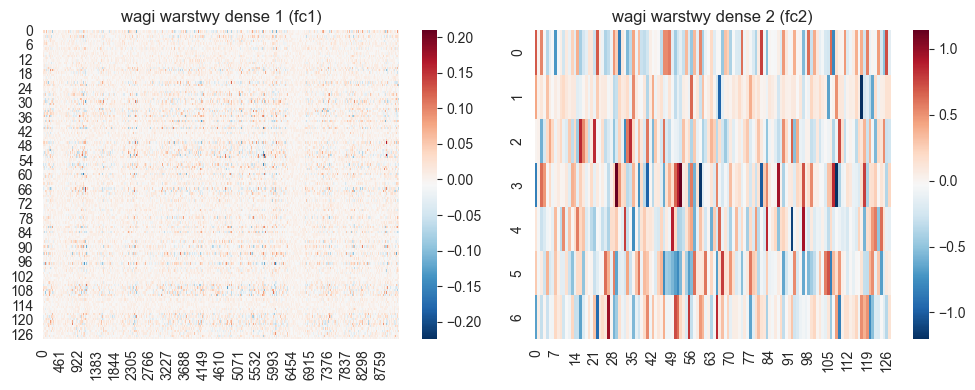

In [97]:
#10 wizualizacja wag w fc1 i fc2

#wagi w warstwach dense
fw1 = model.fc1.weight.detach().cpu().numpy()
fw2 = model.fc2.weight.detach().cpu().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(fw1, cmap='RdBu_r')
plt.title("wagi warstwy dense 1 (fc1)")
plt.subplot(1,2,2)
sns.heatmap(fw2, cmap='RdBu_r')
plt.title("wagi warstwy dense 2 (fc2)")
plt.tight_layout()
plt.show()


macierz pomyłek:
 [[ 450   12  113   90  121  132   40]
 [  24   49    8   10    8    9    3]
 [ 139    4  432   73   96  184   96]
 [ 111    4   87 1252  162  112   46]
 [ 157    8  135  130  574  196   33]
 [ 175   14  188  122  224  476   48]
 [  52    2   65   51   45   23  593]]

raport klasyfikacji:
               precision    recall  f1-score   support

       angry       0.41      0.47      0.44       958
     disgust       0.53      0.44      0.48       111
        fear       0.42      0.42      0.42      1024
       happy       0.72      0.71      0.72      1774
     neutral       0.47      0.47      0.47      1233
         sad       0.42      0.38      0.40      1247
    surprise       0.69      0.71      0.70       831

    accuracy                           0.53      7178
   macro avg       0.52      0.51      0.52      7178
weighted avg       0.53      0.53      0.53      7178


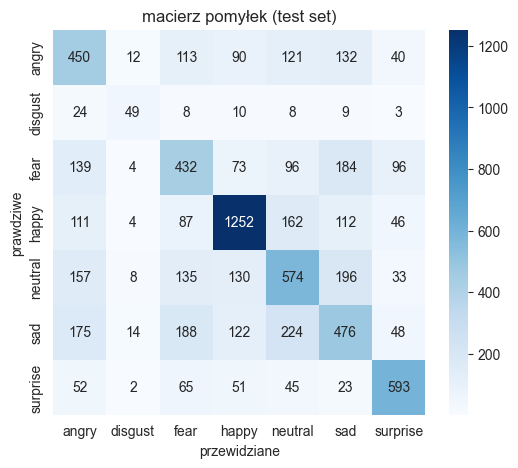

In [98]:
#11 macierz pomyłek i raport
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        out = model(inputs)
        _, preds = torch.max(out,1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
print("\nmacierz pomyłek:\n", cm)
print("\nraport klasyfikacji:\n", 
      classification_report(all_targets, all_preds, target_names=emotions))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions, yticklabels=emotions)
plt.title("macierz pomyłek (test set)")
plt.xlabel("przewidziane")
plt.ylabel("prawdziwe")
plt.show()

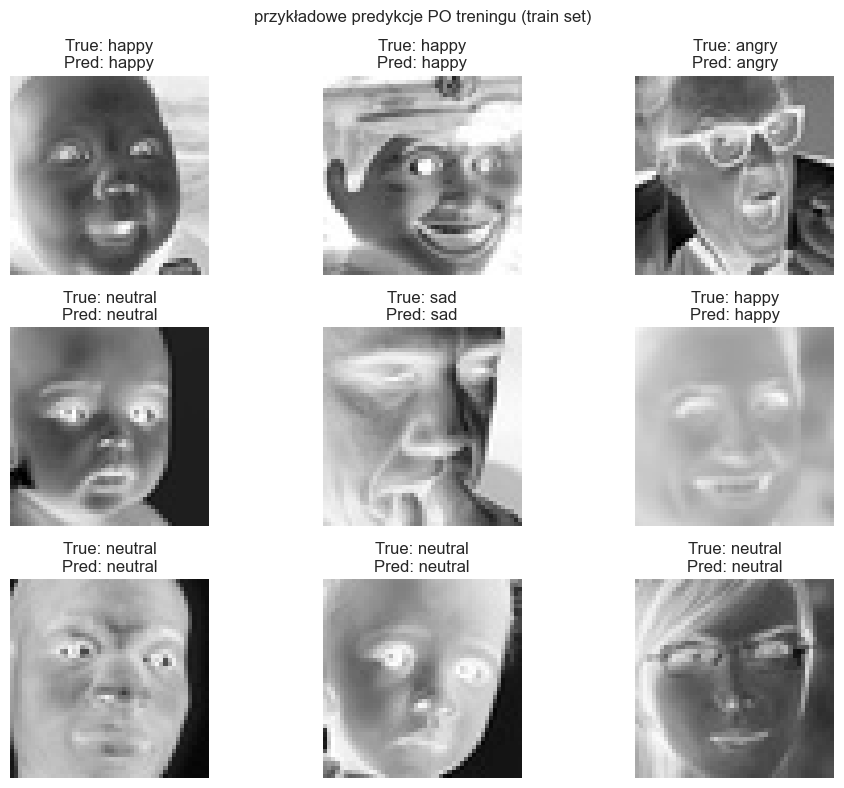

In [99]:
#12 predykcje PO treningu
fig, axes = plt.subplots(3, 3, figsize=(10,8))
axes = axes.flatten()
with torch.no_grad():
    for i in range(9):
        idx = random.randint(0, len(X_train_np)-1)
        img_2d = X_train_np[idx][0]
        true_label = y_train_np[idx]

        img_tensor = torch.from_numpy(X_train_np[idx]).unsqueeze(0).to(device)
        out = model(img_tensor)
        _, pred_label = torch.max(out,1)
        pred_label = pred_label.item()

        axes[i].imshow(img_2d, cmap='gray_r', vmin=0, vmax=1)
        axes[i].set_title(f"True: {emotions[true_label]}\nPred: {emotions[pred_label]}")
        axes[i].axis('off')

plt.suptitle("przykładowe predykcje PO treningu (train set)")
plt.tight_layout()
plt.show()
